LISET DES MEMBRES DU GROUPE

1) FEDOUNG SANOU Armel

2) FOMBA DAOUDA

3) LALOU REDA

# EXERCICE 1

In [1]:
import base
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
env = base.Maze()

On considère la politique suivante applicable dans les environnements de type Maze : dans chaque
état appliquer les probabilités d'actions {W: 0.1, S:0.4, E:0.4, N:0.1}.

In [3]:
pi = np.array([0.1, 0.4, 0.4, 0.1])

In [4]:
def calculer_q(env, v, gamma):
    return np.sum(env.p() * 
            (env.r() + gamma*v[np.newaxis, np.newaxis, :]), axis=2)

In [5]:
def ipe(env, pi, gamma, epsilon):
    ns = env.get_nb_states()
    v = np.zeros((ns))
    q = calculer_q(env, v, gamma)
    nv = np.sum(pi * q, axis=1)
    
    delta = np.sum(np.abs(nv - v))
    while delta > epsilon:
        v = nv
        q = calculer_q(env, v, gamma)
        nv = np.sum(pi * q, axis=1)
        delta = np.sum(np.abs(nv - v))
        
    return nv 

In [6]:
def monte_carlo_predict(env, pi, gamma, nbEpisode, epsilon):
    na = env.get_nb_actions()
    ns = env.get_nb_states()
    q = np.zeros((env.get_nb_states()))
    n = np.zeros((env.get_nb_states()))

    #définition de la politique par défaut
    if pi is None:
        pi = np.ones((ns, na))/na

    V2 = ipe(env, pi, gamma, epsilon)
    V = np.zeros((ns))
    error = []

    for k in range(1, nbEpisode+1):
        # Faire un episode
        s = env.reset()
        episode = []
        while not env.is_final(s):
            a = np.random.choice(na, p=pi) 
            ns, r, _, _ = env.step(a)
            episode.append([s, a, ns, r])
            s = ns
            
        # Mettre à jour Q
        retour = 0
        for s, a, ns, r in reversed(episode):
            retour = r + gamma * retour
            n[s] += 1
            q[s] += retour
            V[s] = q[s]/n[s]
        
        current_error = np.linalg.norm(V2-V)
        error.append(current_error)
        
    #return q/n
    return error

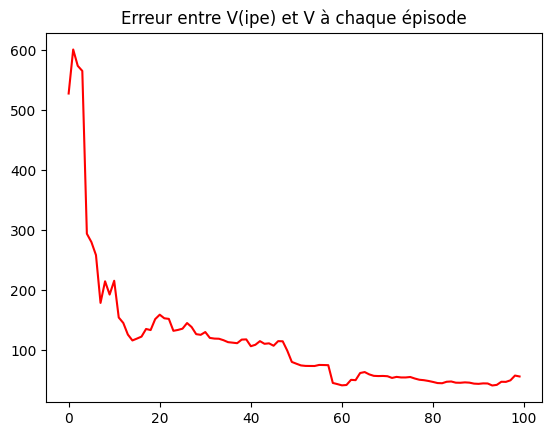

In [7]:
error = monte_carlo_predict(env, pi, 0.9, 100, 0.01)

plt.title("Erreur entre V(ipe) et V à chaque épisode")
plt.plot(error, color="red")

plt.show()

In [8]:
def TD_0(env, pi, alpha, gamma, nbEpisode, epsilon):

    na = env.get_nb_actions()
    ns = env.get_nb_states()

    V = np.zeros((ns))

    error = []
    
    #définition de la politique par défaut
    if pi is None:
        pi = np.ones((ns, na))/na
    
    V2 = ipe(env, pi, gamma, epsilon)

    for k in range(1, nbEpisode+1):
        # Faire un episode
        s = env.reset()
        while not env.is_final(s):
            a = np.random.choice(na, p=pi) 
            ns, r, _, _ = env.step(a)
            #episode = (s, a, ns, r)
            V[s] = V[s] + alpha * (r + gamma * V[ns] - V[s])
            s = ns
        current_error = np.linalg.norm(V2-V)
        error.append(current_error)
    #return V
    return error
           

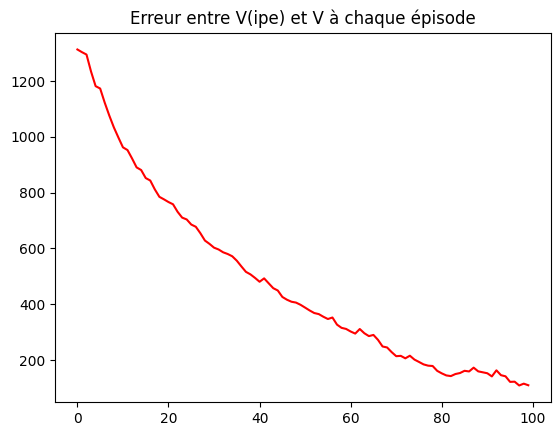

In [9]:
error = TD_0(env, pi, 0.1, 0.9, 100, 0.01)

plt.title("Erreur entre V(ipe) et V à chaque épisode")
plt.plot(error, color="red")

plt.show()

L'algorithme Monte-Carlo est plus performant car sa courbe décroit plus rapidement!

# EXERCICE 2

Implémentation des méthodes

##### Méthode greedy

In [10]:
def greedy(q): # récuperer l'action ayant le meilleur "retour"
    p = np.zeros(q.shape)
    for s in range(p.shape[0]):
        p[s, np.argmax(q[s])] = 1
    return p

##### Méthode egreedy

In [11]:
def egreedy(q, epsilon): #Retourne l'action ayant le meilleur retour avec une probabilité de 1-epsilon et une autre action avec une probabilité epsilon
    ns = q.shape[0] 
    na = q.shape[1]
    p = np.zeros(q.shape) + epsilon / na 
    for s in range(ns):
        p[s, np.argmax(q[s])] += 1 - epsilon
    return p

def egreedyDecision(qvalues, state, epsilon): # same as egreedy ?
    if np.random.rand()<epsilon:
        return np.random.randint(0, qvalues.shape[1])
    else:
        return np.argmax(qvalues[state])

##### Méthode softmax

In [12]:
def softmax(q_, temp):
    q = q_.copy()
    q = q.T - np.max(q, axis=1)
    q = q.T
    pi = (np.exp(q/temp).T / np.sum(np.exp(q/temp), axis=1)).T
    return pi


def softmaxDecision(s, q_, temp):
    q = q_.copy()
    q = q.T - np.max(q, axis=1)
    q = q.T
    pi = (np.exp(q/temp).T / np.sum(np.exp(q/temp), axis=1)).T
    return np.random.choice(q.shape[1], p=pi[s])

##### Méthode qlearning avec egreedy

In [13]:
def qlearning(env, gamma, alpha, epsilon_temp, nb_ep_limit,d, method="egreedy", m=100):
    na = env.get_nb_actions()
    q = np.zeros((env.get_nb_states(), na))
    if method == "greedy_opt":
        q = np.random.randn(env.get_nb_states() * na).reshape((env.get_nb_states(), na)) + m
    retourTotal = np.zeros(nb_ep_limit)
    actionTotal = np.zeros(nb_ep_limit)
    epsilonTmp= epsilon_temp

    for k in range(1, nb_ep_limit+1):     
        s = env.reset()
        retourEpisode = 0 
        ep_len = 0 
        while not env.is_final(s):
            ep_len += 1
            if method == "egreedy": a = egreedyDecision(q, s, epsilon_temp)
            elif method == "softmax": a = softmaxDecision(s, q, temp=epsilon_temp)
            elif method == "greedy_opt": a = np.argmax(q[s])
            ns, r, _, _ = env.step(a)
            q[s, a] += alpha * (r + gamma * np.max(q[ns]) - q[s, a])
            s = ns
            retourEpisode += r
        retourTotal[k-1] = retourEpisode
        actionTotal[k-1] = ep_len

        # Mettre à jour epsilon et pi
        if(k > d):
            epsilon_temp = epsilonTmp/np.sqrt(k-d)

    return retourTotal, actionTotal

[1000. 1000. 1000. 1000.  400.  400.  400.  400.  400.  400.  400.  400.
  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.
  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.
  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.
  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.
  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.
  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.
  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.  400.
  400.  400.  400.  400.]


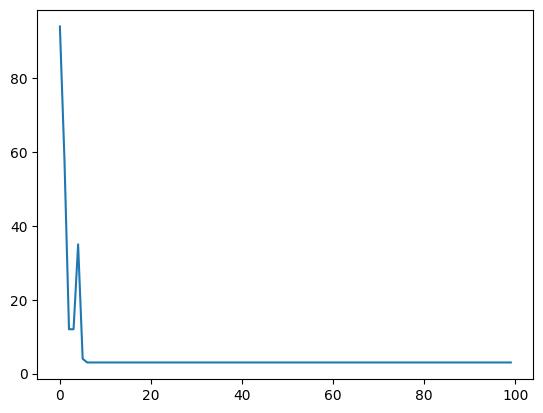

In [14]:
qLningRetourTotal, qLningActionTotal= qlearning(env, gamma=0.99, alpha=0.9, epsilon_temp=0.1, nb_ep_limit=100, d=50, method="softmax")
print(qLningRetourTotal)
plt.plot(range(len(qLningActionTotal[0:])), qLningActionTotal[0:])

[400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400. 400.]


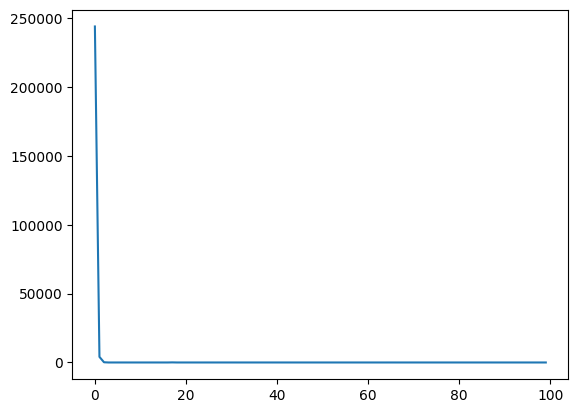

In [15]:
qLningRetourTotal, qLningActionTotal= qlearning(env, gamma=0.6, alpha=0.1, epsilon_temp=0.1, nb_ep_limit=100, d=50, method="egreedy", m=1000)
print(qLningRetourTotal)
plt.plot(range(len(qLningActionTotal[0:])), qLningActionTotal[0:])

##### Méthode qlearning avec softmax

In [16]:
def sarsa(env, gamma, alpha, epsilon_temp, nb_ep_limit,d, method="egreedy", m=100):
    na = env.get_nb_actions()
    q = np.zeros((env.get_nb_states(), na))
    if method == "greedy_opt":
        q = np.random.randn(env.get_nb_states() * na).reshape((env.get_nb_states(), na)) + m
    retourTotal = np.zeros(nb_ep_limit)
    actionTotal = np.zeros(nb_ep_limit)
    epsilonTmp= epsilon_temp

    for k in range(1, nb_ep_limit+1):      
        s = env.reset()

        if method == "egreedy": a = egreedyDecision(q, s, epsilon_temp)
        elif method == "softmax": a = softmaxDecision(s, q, temp=epsilon_temp)
        elif method == "greedy_opt": a = np.argmax(q[s])

        retourEpisode = 0 
        ep_len = 0 

        while not env.is_final(s):
            ep_len += 1
            ns, r, _, _ = env.step(a)
            
            if method == "egreedy": na = egreedyDecision(q, ns, epsilon_temp)
            elif method == "softmax": na = softmaxDecision(ns, q, temp=epsilon_temp)
            elif method == "greedy_opt": na = np.argmax(q[ns])

            q[s, a] += alpha * (r + gamma * (q[ns, na]) - q[s, a])
            s = ns
            a = na 
            retourEpisode += r
        retourTotal[k-1] = retourEpisode
        actionTotal[k-1] = ep_len

        # Mettre à jour epsilon et pi
        if(k > d):
            epsilon_temp = epsilonTmp/np.sqrt(k-d)
    
    return retourTotal, actionTotal   

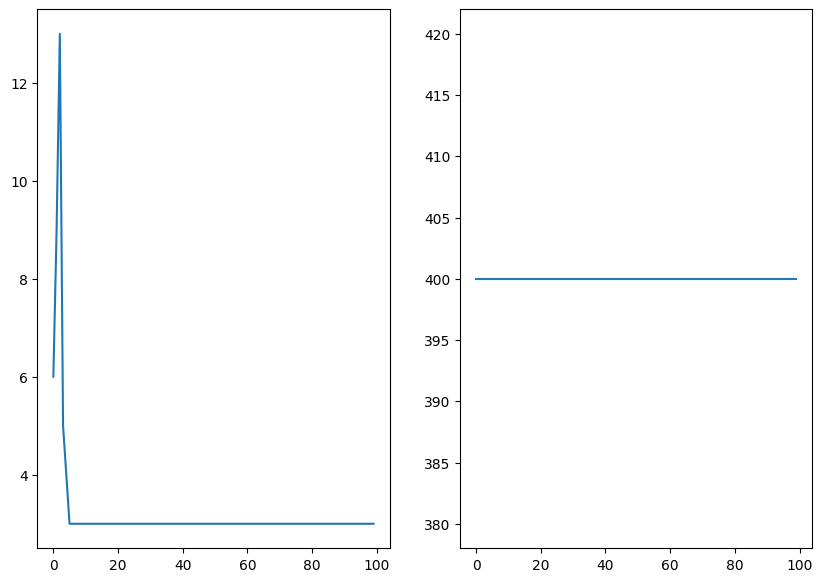

In [17]:
sarsaRetourTotal, sarsaActionTotal= sarsa(env, gamma=0.4, alpha=0.1, epsilon_temp=0.1, nb_ep_limit=100, d=50, method="softmax", m=100)
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
axes[0].plot(range(len(sarsaActionTotal[0:])), sarsaActionTotal[0:])
axes[1].plot(range(len(sarsaRetourTotal)), sarsaRetourTotal)

##### Méthode monte carlo GLIE

In [18]:
def monte_carlo_GLIE(env, gamma, alpha, epsilon_temp, nb_ep_limit,d, method="egreedy"):
    na = env.get_nb_actions()
    q = np.zeros((env.get_nb_states(), na))
    n = np.zeros((env.get_nb_states(), na))
    

    retourTotal = np.zeros(nb_ep_limit)
    actionTotal = np.zeros(nb_ep_limit)
    epsilonTmp = epsilon_temp
    epsilonTempTrack = []

    if method == "egreedy": pi = egreedy(q, epsilon_temp)
    elif method == "softmax": pi = softmax(q, temp=epsilon_temp)

    for k in range(1, nb_ep_limit+1):
        # Faire un episode
        s = env.reset()
        episode = []
        retourEpisode = 0 
        ep_len = 0 

        while not env.is_final(s):
            a = np.random.choice(na, p=pi[s]) 
            ns, r, _, _ = env.step(a)
            episode.append([s, a, ns, r])
            s = ns
            retourEpisode += r
            ep_len += 1
        retourTotal[k-1] = retourEpisode
        actionTotal[k-1] = ep_len
            
        # Mettre à jour Q
        retour = 0
        # actionTotal[k-1] = len(episode)
        for s, a, ns, r in reversed(episode):
            retour = r + gamma * retour
            n[s, a] += 1
            q[s, a] += 1/n[s, a]*(retour - q[s, a])
       
        # Mettre à jour epsilon et pi
        if(k> d):
            epsilon_temp = epsilonTmp/np.sqrt(k-d)
            epsilonTempTrack.append(epsilon_temp)
            
        if method == "egreedy": pi = egreedy(q, epsilon_temp)
        elif method == "softmax": pi = softmax(q, temp=epsilon_temp)
        
    return retourTotal, actionTotal, epsilonTempTrack

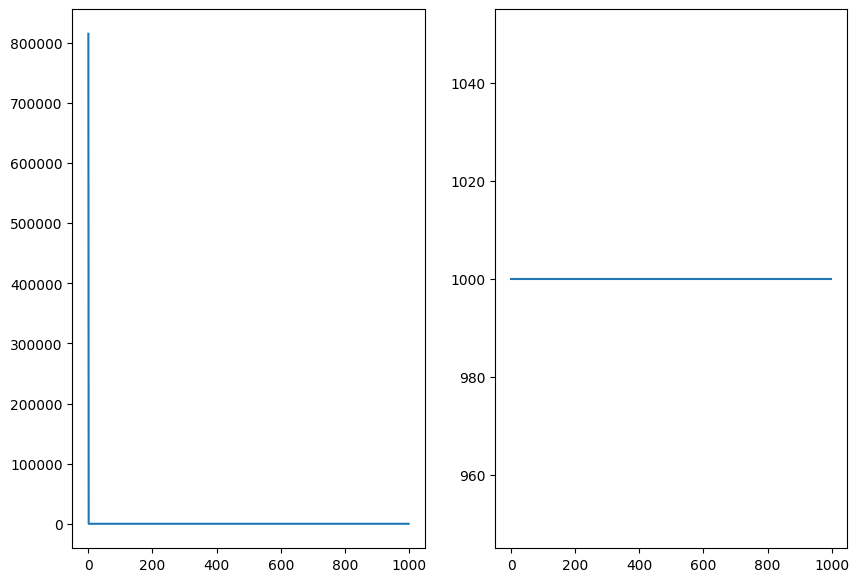

In [19]:
monteCarloRetourTotal, monteCarloActionTotal, epsilonTempTrack = monte_carlo_GLIE(env, gamma=0.9, alpha=0.1, epsilon_temp=0.05, nb_ep_limit=1000, d=50, method="egreedy")
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
axes[0].plot(range(len(monteCarloActionTotal[0:])), monteCarloActionTotal[0:])
axes[1].plot(range(len(monteCarloRetourTotal)), monteCarloRetourTotal)

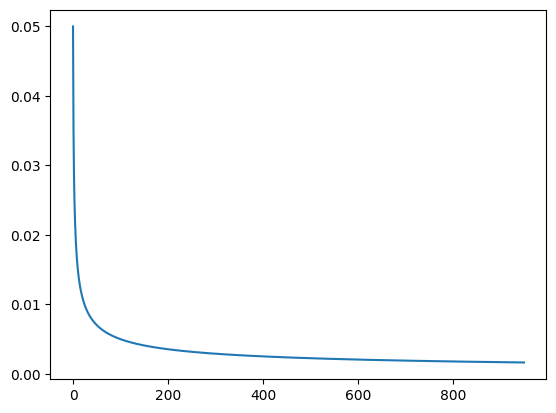

In [20]:
epsilonTempTrack
plt.plot(range(len(epsilonTempTrack)), epsilonTempTrack)